In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# models
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow import keras
from keras import layers, Sequential
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Exploring Data

In [2]:
# reading data
trainData = pd.read_csv("dataset/train.csv")
testData = pd.read_csv("dataset/test.csv")

In [3]:
# separating images and labels
images, labels = trainData.iloc[:, 1:], trainData['label']

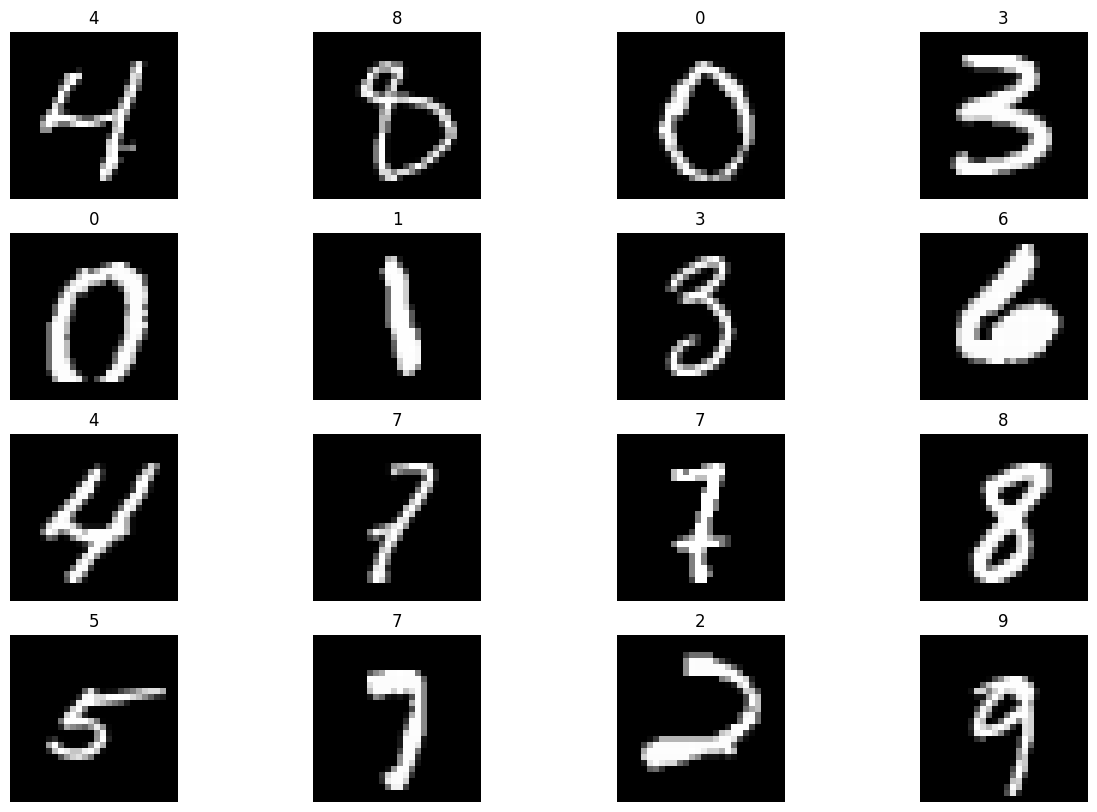

In [4]:
# displaying images
def displayImg(images, title):
    plt.figure(figsize=(15, 10))
    
    for i in range(len(images)):
        plt.subplot(4, 4, i+1)
        plt.title(title[i])
        plt.imshow(np.reshape(images[i], (28, 28)), cmap='gray')
        plt.axis('off')
    plt.show()
    
rand = np.random.randint(0, images.shape[0]-16)
displayImg(images.iloc[rand:rand+16].values, labels.iloc[rand:rand+16].values)

# Preprocessing Data

In [5]:
trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.20, random_state=0)

In [6]:
# reshaping data and scaling it from 0 to 1    
trainX = trainX.to_numpy().reshape(-1, 28, 28, 1) / 255
testX = testX.to_numpy().reshape(-1, 28, 28, 1) / 255

# Training Model

In [7]:
def createModel(learningRate, optimizer, activation, dropoutRate):
    model = Sequential([
        layers.Conv2D(32, (5, 5), activation=activation, input_shape=(28, 28, 1)),
        layers.MaxPool2D((2, 2)),

        layers.Conv2D(64, (5, 5), activation=activation),
        layers.MaxPool2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(dropoutRate),

        layers.Dense(64, activation=activation),
        layers.BatchNormalization(),

        layers.Dense(32, activation=activation),
        layers.BatchNormalization(),
        
        layers.Dropout(dropoutRate),

        layers.Dense(10, activation='softmax')
    ])

    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learningRate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learningRate)
        
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
# adding callback to avoid overfitting
earlyStopping = EarlyStopping(
    min_delta=0.005,
    patience=10,
    restore_best_weights=True
)

## Hyperparameter Tuning

**Note** : *This part of code is commented because it takes a lot of time to run.*

In [9]:
paramGrid = {
    'batch_size' : [16, 32],
    'learningRate' : [0.001, 0.01, 0.1],
    'optimizer' : ['adam', 'sgd'],
    'dropoutRate' : [0.1, 0.2],
    'activation' : ['relu', 'tanh']
}

In [ ]:
# model = KerasClassifier(build_fn=createModel, verbose=0)

# gridSearch = GridSearchCV(model, paramGrid, cv=3, verbose=0).fit(trainX, trainY)

# finding the best parameters
# bestParams = gridSearch.best_params_
# print("Best Paramters :", bestParams)
# {'activation': 'relu', 'batch_size': 16, 'dropoutRate': 0.2, 'learningRate': 0.001, 'optimizer': 'adam'}

In [10]:
# fitting best parameters into model
bestModel = createModel(
    learningRate = 0.001,
    optimizer = 'adam',
    activation = 'relu',
    dropoutRate = 0.2
)

history = bestModel.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    batch_size = 16,
    epochs = 20,
    callbacks = [earlyStopping]
)

Epoch 1/20
2100/2100 [==============================] - 16s 7ms/step - loss: 0.2631 - accuracy: 0.9241 - val_loss: 0.0667 - val_accuracy: 0.9805
Epoch 2/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0988 - accuracy: 0.9713 - val_loss: 0.0538 - val_accuracy: 0.9823
Epoch 3/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0707 - accuracy: 0.9784 - val_loss: 0.0402 - val_accuracy: 0.9877
Epoch 4/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0637 - accuracy: 0.9808 - val_loss: 0.0334 - val_accuracy: 0.9899
Epoch 5/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0511 - accuracy: 0.9842 - val_loss: 0.0311 - val_accuracy: 0.9898
Epoch 6/20
2100/2100 [==============================] - 14s 7ms/step - loss: 0.0439 - accuracy: 0.9872 - val_loss: 0.0341 - val_accuracy: 0.9894
Epoch 7/20
2100/2100 [==============================] - 15s 7ms/step - loss: 0.0401 - accuracy: 0.9882 - val_loss: 0.0380 - val_ac

In [11]:
historyDf = pd.DataFrame(history.history)

<Axes: >

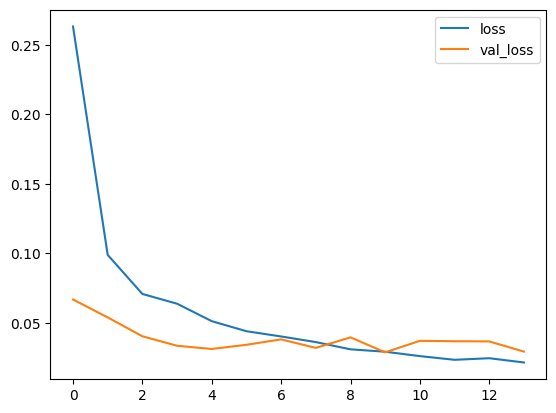

In [12]:
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

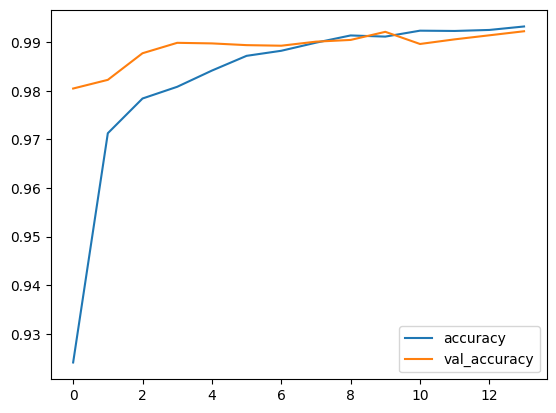

In [13]:
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

# Creating Submission

In [14]:
# reshaping test data
testData = testData.to_numpy().reshape(-1, 28, 28) / 255

In [15]:
# making predictions
pred = list(map(np.argmax, bestModel.predict(testData)))

875/875 [==============================] - 4s 4ms/step


Label predicted : 7 


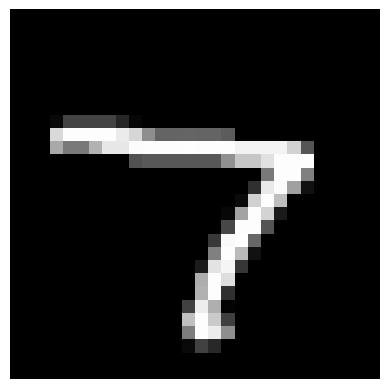

In [22]:
i = np.random.randint(0, 28000)
print('Label predicted :', pred[i], '\n')
plt.imshow(testData[i], cmap='gray')
plt.axis('off')
plt.show()

In [19]:
# creating submission csv
output = pd.DataFrame({'ImageId' : range(1, 28001), 'Label' : pred})
output.to_csv("Digit Recognizer.csv", index=False)